# JWST Science Calibration Pipeline Walkthrough

This notebook walks through how to install and run the JWST Science Calibration Pipeline (the pipeline).  

### Table of Contents:
> #### 1. [Resources and Documentation](#resources)
> #### 2. [Environment Setup](#setup)
> #### 3. [Pipeline Installation](#installation)
> #### 4. [Pipeline Overview](#overview)
> #### 5. [Data Format](#format)
> #### 6. [Configuration Files](#configs)
> #### 7. [Ways to Run the Pipelines](#methods)
> #### 8. [Example Data Set](#data)
> #### 9. [Stage 1 Processing: Ramps-to-slopes](#rampstoslopes)
> #### 10. [Stage 2 Image Processing: Calibrated individual exposures](#image2)
> #### 11. [Stage 3 Image Processing: Source catalogs and mosaics](#image3)
> #### 12. [Stage 2 Spectroscopic Processing: Calibrated individual exposures](#spec2)

***
<a id='resources'></a>
## 1. Resources and Documentation

There are several different places to find information on installing and running the pipeline. This notebook will give a shortened description of the steps pulled from the detailed pipeline information pages, but to find more in-depth instructions use the links below. 

>1. JDox: https://jwst-docs.stsci.edu/display/JDAT/JWST+Data+Reduction+Pipeline
>2. Installation page: http://astroconda.readthedocs.io/en/latest/releases.html#pipeline-install
>3. Detailed pipeline information: https://jwst-pipeline.readthedocs.io/en/latest/jwst/introduction.html
>4. Help Desk (click on Pipeline Support): https://stsci.service-now.com/jwst?id=sc_category&sys_id=e15706fc0a0a0aa7007fc21e1ab70c2f

***
<a id='setup'></a>
## 2. Environment Setup

Conda is a package manager application that installs, runs, and updates packages and their dependencies, and it works on Linux, OS X and Windows. You must have the Conda software installed before you can install the JWST package from the AstroConda channel. Full details on downloading and installing Conda can be found here: https://conda.io/docs/user-guide/install/download.html. 


After installing Conda, you can then install STScI's programs and packages. You'll want to use the Institute’s AstroConda repository by typing in the command line (of your Conda environment):

>`$ conda config --add channels http://ssb.stsci.edu/astroconda`

***
<a id='installation'></a>
## 3. Pipeline Installation

Pipeline release files are snapshots of STScI software and can be used to replicate the environment used by STScI to perform data processing. Upgrading packages with `$ conda update [pkg]` or `$ conda update --all` is **not** recommended (it will likely introduce bugs and/or break the environment).

<div class="alert alert-block alert-warning">**Note:** Python 2.x.x and 32-bit operating systems are not supported.</div>
***

Pipeline release installations use the following command:

>`$ conda create -n [custom_env_name] --file [URL]`

Select the URL that matches your platform and environment (see this link: http://astroconda.readthedocs.io/en/latest/releases.html#file-urls).


Activate the pipeline environment with the command:

>`$ source activate [custom_env_name]`


Example for Mac OS X:

>`$ conda create -n demoenv --file http://ssb.stsci.edu/releases/hstdp/2017.2a/hstdp-2017.2a-osx-py35.final.txt`

>`$ source activate demoenv`

To run the pipeline in this notebook, you must open the notebook from within your pipeline environment. "shift+enter" is the hot key to run a cell of the notebook.

### Development version

To get the latest pipeline version with recent updates and fixes to the Stage 2 and Stage 3 pipeline steps, install the development version.

>`$ conda create -n jwstdev -c http://ssb.stsci.edu/conda-dev jwst`

To update the development version of the pipeline:
    
>`$ conda update --override-channels -c http://ssb.stsci.edu/conda-dev -c defaults --all`

### Reference file access for outside users

People at STScI should automatically have access to the Calibration Reference Data System (CRDS) cache for running the pipeline. For outside users, one arrangement is to have the CRDS server download the reference files to your local system and then use them locally when running the pipeline. To do that, the appropriate instructions are:

>`$ export CRDS_PATH=$HOME/crds_cache`

>`$ export CRDS_SERVER_URL=https://jwst-crds.stsci.edu`

The first time you invoke the pipeline, the Calibration Reference Data System (CRDS) server should download all the context and reference files that are needed and dump them into the CRDS_PATH directory. Subsequent executions of the pipeline will first look to see if it has what it needs in CRDS_PATH and anything it doesn't have will again be downloaded from the STScI cache. Otherwise, reference files will have to be transferred to you via some other method and then copied manually into the CRDS_PATH directory. Of course, if you have local copies of the reference files on your machine, you can manually override the reference files with each pipeline call, but that can be a hassle. 

There is also a way to remotely access reference files in the CRDS cache here at STScI; however, due to network bandwidth limitations that will most likely be very slow and is not discussed here. 

***
<a id='overview'></a>
## 4. Pipeline Overview

The overall structure of the pipeline is shown in the image below. 

Some notes about the current status of processing stages: 

>1. Images: Stage 1, 2, and 3 image processing pipelines are fully working and supported (detailed analysis is still being done on the outputs). The CORON3 pipeline has not been tested extensively yet. 
>2. WFSS: Stage 1 and 2 processing pipelines work on WFSS data, but Stage 3 is not supported at the moment.
>3. TSO: not implemented yet

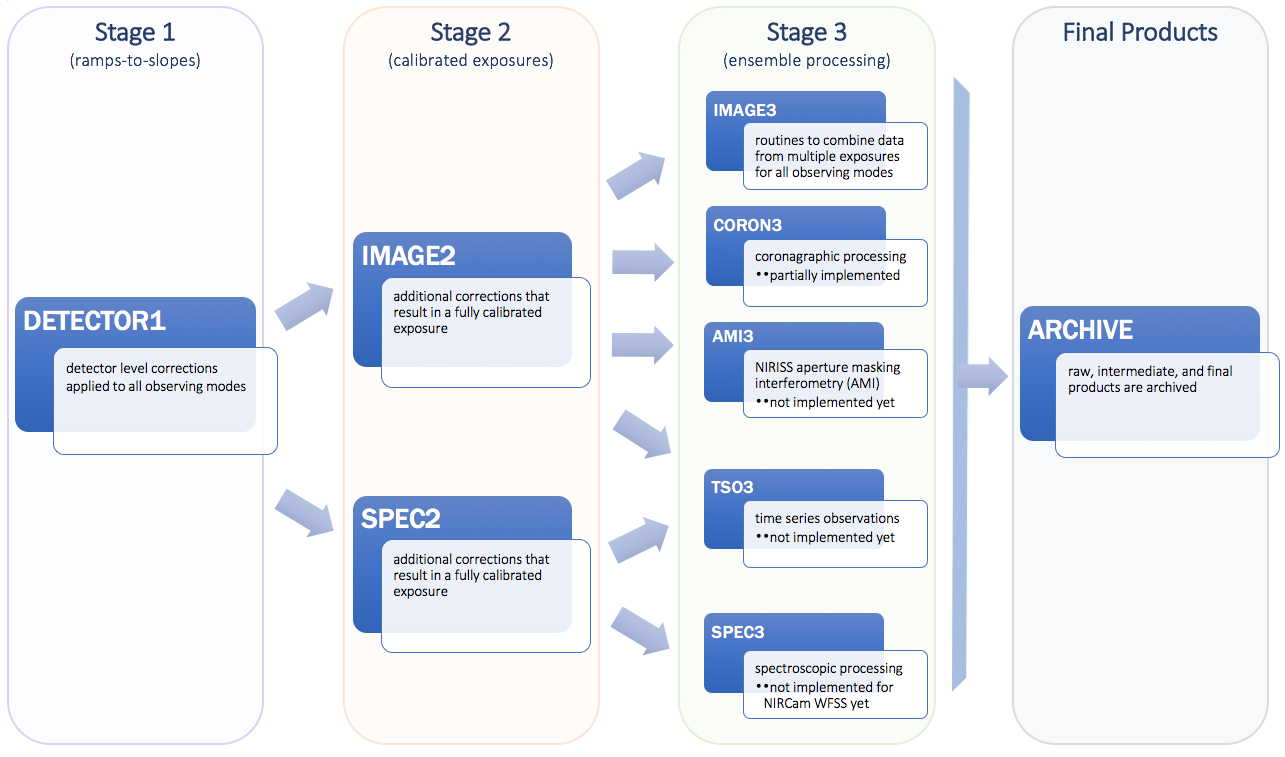

In [1]:
from IPython.display import Image 
Image(filename='pipe_overview.png')

***
<a id='format'></a>
## 5. Data Format

Data Management System (DMS) requires that the data array for imaging and spectroscopy modes (including reference files) be re-oriented to the same orientation with respect to the V2, V3 axes in the focal plane. This requires flipping and rotating the reference pixels and science coordinates. The image below (Diaz et al. 2017, JWST-STScI-005730) shows the raw coordinates of the detector (orange arrows) and those corresponding to the science orientation (blue arrows). Raw orientation is the “native” readout coordinate frame (i.e., FITSWriter output).

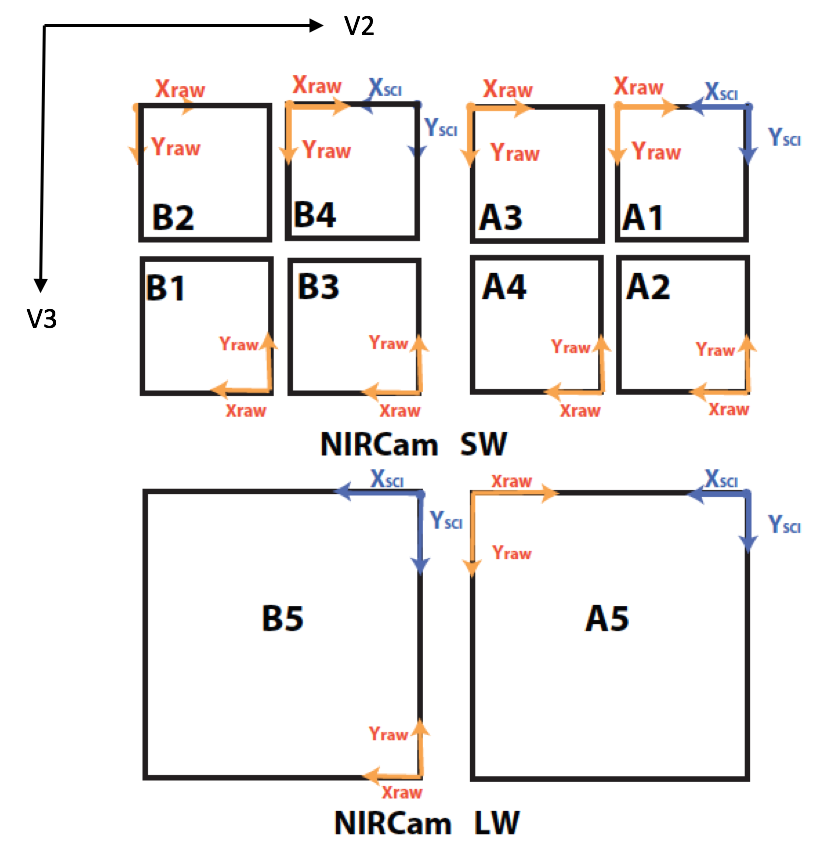

In [6]:
Image(filename='orientation.png')

Aside from orientation, the format of the data going into the pipeline is different from the FITSWriter format. Science data is in the SCI extension, rather than the PRIMARY extension, as shown below: 
  

**FITSWriter format (science data in the PRIMARY extension)**:

        No.    Name         Type      Cards   Dimensions   Format
            0  PRIMARY     PrimaryHDU     381   (320, 320, 20) int16 (rescales to uint16)  
            1  ENG         BinTableHDU     15   78148R x 3C  [30A, 30A, 30A

**DMS format (science data in the SCI extension)**:

        No.    Name         Type      Cards   Dimensions   Format
            0  PRIMARY       1 PrimaryHDU      69   ()    
            1  SCI           1 ImageHDU        38   (2048, 2048, 10, 1)   int16 (rescales to uint16)  
            2  ZEROFRAME     1 ImageHDU        11   (2048, 2048, 1)   int16 (rescales to uint16)  
            3  GROUP         1 BinTableHDU     35   10R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D] 

***
<a id='configs'></a>
## 6. Configuration Files

<div class="alert alert-block alert-warning">**Note:** To avoid having to deal with a bunch of configuration files, we will show how to change the parameters within iPython in the [next](#methods) section.</div>
***


Configuration files tell the pipeline how to run the pipeline steps. You can get them by typing in the command line:

>`$ collect_pipeline_cfgs ./`


This grabs all configuration files, for all steps, for all JWST Instruments. The default parameters in the config files are not all optimized for NIRCam. For example, the reference pixel correction step config file ("refpix.cfg") needs to be edited so that the mean value in the reference pixels for each amplifier is calculated separately for odd and even rows (there is a significant odd-even row effect).

Change the "refpix.cfg" file to match the example below and save it:

        name = "refpix"
        class = "jwst.refpix.RefPixStep"
        odd_even_columns = True
        use_side_ref_pixels = True
        side_smoothing_length=11
        side_gain=1.0
        odd_even_rows = False
        
There are other parameters that can be tweaked inside the different config files (e.g., the jump detection threshold in the "jump.cfg" file might need to be increased to avoid a lot of false-flagging in the jump detection step). Each individual step uses a configuration file, and the calwebb_*.cfg files contain all steps for each stage of processing. To run the Ramps-to-slopes pipeline for NIRCam, you can edit the configuration file to match the example below and save it: 

        name = "Detector1Pipeline"
        class = "jwst.pipeline.Detector1Pipeline"
        save_calibrated_ramp = False

            [steps]
              [[group_scale]]
                skip = True
              [[dq_init]]
                config_file = dq_init.cfg
              [[saturation]]
                config_file = saturation.cfg
              [[ipc]]
                skip = True
              [[superbias]]
                config_file = superbias.cfg
              [[refpix]]
                config_file = refpix.cfg
              [[rscd]]
                skip = True
              [[lastframe]]
                skip = True
              [[linearity]]
                config_file = linearity.cfg
              [[dark_current]]
                skip = True
              [[persistence]]
                skip = True
              [[jump]]
                config_file = jump.cfg
              [[ramp_fit]]
                config_file = ramp_fit.cfg
              [[gain_scale]]
                skip = True

***
<a id='methods'></a>
## 7. Ways to Run the Pipelines

   ### Command line method

The full stages and individual steps of the processing stages can be run via the command line as follows:

>`$ strun dq_init.cfg uncalibrated_file.fits`

Any step overrides or parameter changes are just added as shown below:

>`$ strun dq_init.cfg uncalibrated_file.fits override_mask="new_mask.fits"`

or 

>`$ strun dq_init.cfg uncalibrated_file.fits output_file="output_file_dq.fits"`

   ### iPython: Module method

It is easier to run the pipeline from within iPython, as it allows for quick tweaks to the parameters without having to open and re-save config files. You can simply start up iPython from within your pipeline environment:

>`$ ipython`

Then use the module to run individual steps and tweak the parameters. For example, to run the Stage 1 pipeline to generate slope images:

```python
# import the pipeline you want to run (e.g., ramps-to-slopes)
from jwst.pipeline import calwebb_detector1

# initialize
m = calwebb_detector1.Detector1Pipeline(config_file='calwebb_detector1.cfg')

# make changes to the parameters/reference files used
m.saturation.override_saturation = 'mysatfile.fits'
m.superbias.override_superbias = 'mysuperbias.fits'
m.refpix.odd_even_rows = False

# skip steps you don't want to run
m.group_scale.skip = True
m.ipc.skip = True
m.dark_current.skip = True
m.persistence.skip = True

# name your output file
m.output_file = 'myoutputfilename.fits'

# run the pipeline with these paramters
m.run('uncalfile.fits')
```        
        
Or you can write Python scripts that use those methods to run the pipelines.         

   ### iPython: Class method

The Class method is also relatively convenient, though you still have to edit the configuration files to make tweaks to individual step parameters: 

```python
# import the pipeline you want to run (e.g., ramps-to-slopes) or the step (data quality initialization)
from jwst.pipeline import Detector1Pipeline
from jwst.dq_init import DQInitStep

# override the default cfg file with "config_file="
Detector1Pipeline.call('uncalfile.fits',config_file='calwebb_detector1.cfg',output_file='calfile.fits')

# to run an individual step:
dq_step = DQInitStep.call('uncalfile.fits',output_file='dqonly.fits')

# dq_step will have attributes:
dq_step.data, dq_step.groupdq
```        

Get help with pipeline steps by typing: 

```python
help(Detector1Pipeline)
``` 


***
<a id='data'></a>
## 8. Example Data Set

In order to demonstrate the imaging pipeline from ramps-to-slopes to image combination (and show part of the spectroscopy pipeline), I will use simulated data generated using Bryan Hilbert's NIRCam Simulator (2018, in prep). This is a set of grism observations consisting of 12 pointings (3 dither positions, with 4 subpixel dithers) for both row and column dispersed spectra. There are also associated direct images and out-of-field observations, along with associated shortwave channel imaging mode data. 

For the imaging pipeline we use:
* module A (SW)
* 8 pointings: 2 primary dithers, 4 subpixel dithers 

For the spectroscopy pipeline we use:
* module A (LW), row dispersed
* 1 pointing: 1 primary dither, 1 subpixel dither

Below is an image of the footprint of this set of observations, to give you an idea of what our final combined image should resemble. 

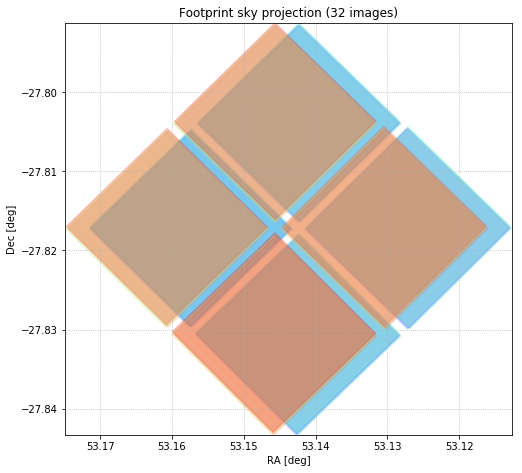

In [7]:
Image(filename='footprint.png')

***
<a id='rampstoslopes'></a>
## 9. Stage 1 Processing: Ramps-to-slopes

<div class="alert alert-block alert-warning">**Note:** I will use iPython Method 1 to run the pipeline, as an example.</div>
***

Stage 1 (Detector1, calwebb_detector1) processing applies detector-level corrections to all exposure types (imaging, spectroscopic, coronagraphic, etc.) one exposure at a time. The pipeline module for stage 1 processing is calwebb_detector1, and the pipeline class is Detector1Pipeline.

> **Inputs**: single raw 4D exposure file containing the original raw data from all of the detector readouts in the exposure (ncols x nrows x ngroups x nintegrations).

> **Outputs**: a 2D countrate product, resulting from averaging over all of the integrations within the exposure, and a 3D countrate product for exposures with more than one integration (NINTS>1) that contains individual results for each integration. The output exposure will have suffix "rate" or "rateints".


Steps for NIRCam:


**Data quality initialization** (jwst.dq_init, dq_init_step, DQInitStep)
* Reference file: bad pixel mask

**Saturation check** (jwst.saturation, saturation_step, SaturationStep)
* Reference file: saturation map
    
**Superbias subtraction** (jwst.superbias, superbias_step, SuperBiasStep)
* Reference file: superbias 
    
**Reference pixel correction** (jwst.refpix, refpix_step, RefPixStep)

**Linearity correction** (jwst.linearity, linearity_step, LinearityStep)
* Reference files: linearity correction coefficients
    
(implemented soon) **Persistence** (jwst.persistence, persistence_step, PersistenceStep)
* Reference files: trap density, persistence saturation, trap parameters
    
**Jump Detection** (jwst.jump, jump_step, JumpStep)
* Reference files: gain, readnoise
    
**Ramp-fitting** (jwst.ramp_fit, ramp_fit_step, RampFitStep)
* Reference files: gain, readnoise

(for more information on individual steps see: https://jwst-pipeline.readthedocs.io/en/latest/jwst/package_index.html)

   ### Running the pipeline

Below, we show how to run a single step, the full stage 1 pipeline for a single exposure, and the full stage 1 pipeline for all 32 exposures with multiprocessing. Note that for the Python methods, unless an output file is specified, nothing gets written out. You will have to manually save out the file as follows:

>`m.save("youroutput.fits")`

In [ ]:
# Single exposure and full pipeline ---------------------------------------------------------------

from jwst.pipeline import calwebb_detector1

# file to calibrate and reference files 
infile = "V54321001002P0000000001108_A1_F150W_uncal.fits"
outfile = infile[:-5]+"_rate_example.fits"
saturationfile = "jwst_nircam_saturation_0064.fits"
superbiasfile = "jwst_nircam_superbias_0026.fits"


m = calwebb_detector1.Detector1Pipeline(config_file='calwebb_detector1.cfg')

# make changes to the parameters/reference files used
m.saturation.override_saturation = saturationfile
m.superbias.override_superbias = superbiasfile
m.refpix.odd_even_rows = False

# skip steps you don't want to run
m.group_scale.skip = True
m.ipc.skip = True
m.dark_current.skip = True
m.persistence.skip = True

# name your output file
m.output_file = outfile

# run the pipeline with these paramters
m.run(infile)

In [ ]:
# Single step of the pipeline ---------------------------------------------------------------

from jwst.saturation import saturation_step

# file to calibrate and reference files 
infile = "V54321001002P0000000001108_A1_F150W_uncal.fits"
outfile = infile[:-5]+"_rate_example.fits"
saturationfile = "jwst_nircam_saturation_0064.fits"


m = saturation_step.SaturationStep(config_file='saturation.cfg')

# make changes to the parameters/reference files used
m.override_saturation = saturationfile

# name your output file
m.output_file = outfile

# run the pipeline with these paramters
m.run(infile)

## Alternative Class method 
## e.g., dq.data holds the output data, dq.pixeldq holds the Pixel DQ array
# from jwst.saturation import SaturationStep
# 
# dq = SaturationStep.call(infile,override_satruation=saturationfile,output_file=outfile)
# dq.data, dq.groupdq

In [ ]:
# Single exposure and full pipeline ---------------------------------------------------------------

from jwst.pipeline import calwebb_detector1

# file to calibrate and reference files 
infile = "V54321001002P0000000001108_A1_F150W_uncal.fits"
outfile = infile[:-5]+"_rate_example.fits"
saturationfile = "jwst_nircam_saturation_0064.fits"
superbiasfile = "jwst_nircam_superbias_0026.fits"


m = calwebb_detector1.Detector1Pipeline(config_file='calwebb_detector1.cfg')

# make changes to the parameters/reference files used
m.saturation.override_saturation = saturationfile
m.superbias.override_superbias = superbiasfile
m.refpix.odd_even_rows = False

# skip steps you don't want to run
m.group_scale.skip = True
m.ipc.skip = True
m.dark_current.skip = True
m.persistence.skip = True

# name your output file
m.output_file = outfile

# run the pipeline with these paramters
m.run(infile)

In [ ]:
# Multiple exposures and full pipeline with multiprocessing ------------------------------------------

from multiprocessing import Pool
from jwst.pipeline import calwebb_detector1

# Number of cores available for processing.
N_PROCS = 5  

def calwebb_detector1(infile,saturationfile,superbiasfile):
    """Run Stage 1 pipeline for input image."""    
    
    outfile = infile[:-5]+"_rate.fits"
    
    m = calwebb_detector1.Detector1Pipeline(config_file='calwebb_detector1.cfg')

    # make changes to the parameters/reference files used
    m.saturation.override_saturation = saturationfile
    m.superbias.override_superbias = superbiasfile
    m.refpix.odd_even_rows = False

    # skip steps you don't want to run
    m.group_scale.skip = True
    m.ipc.skip = True
    m.dark_current.skip = True
    m.persistence.skip = True

    # name your output file
    m.output_file = outfile

    # run the pipeline with these paramters
    m.run(infile)

# get list of files to process
files_to_process = glob('*_uncal.fits')

# run the pipeline for all files
with Pool(N_PROCS) as pool:
    pool.map(calwebb_detector1, files_to_process)

The image below shows one frame of our example exposure, and the slope image output from calwebb_detector1.

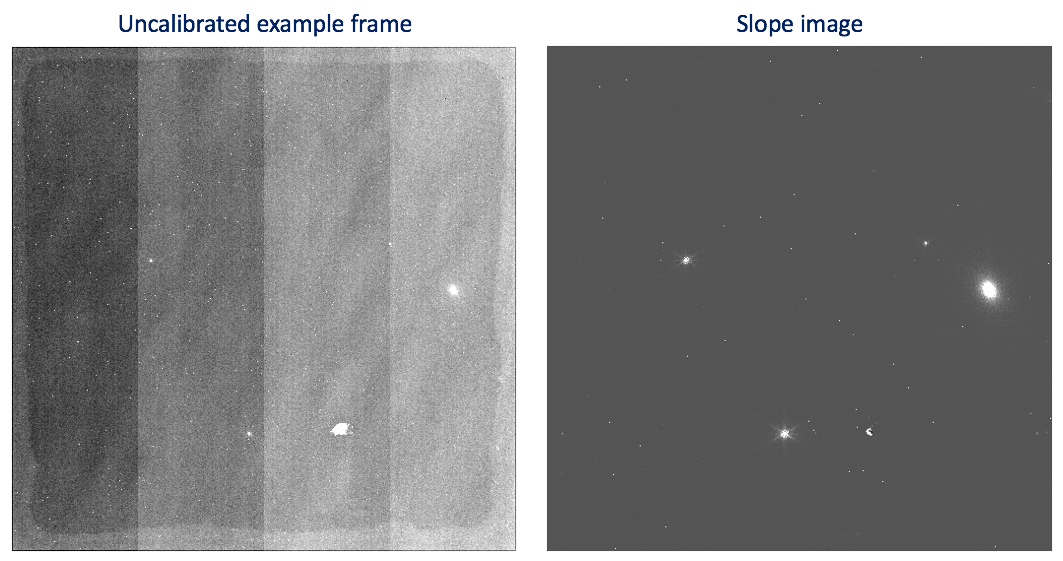

In [8]:
Image("detector1_example.png")

Here is the data format before Stage 1 processing: 

In [4]:
from astropy.io import fits
fits.info("V54321001002P0000000001108_A1_F150W_uncal.fits")

Filename: V54321001002P0000000001108_A1_F150W_uncal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      69   ()      
  1  SCI           1 ImageHDU        38   (2048, 2048, 10, 1)   int16 (rescales to uint16)   
  2  ZEROFRAME     1 ImageHDU        11   (2048, 2048, 1)   int16 (rescales to uint16)   
  3  GROUP         1 BinTableHDU     35   10R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   


Here is the data format after Stage 1 processing: 

In [48]:
fits.info("V54321001002P0000000001108_A1_F150W_rate.fits")

Filename: V54321001002P0000000001108_A1_F150W_rate.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     138   ()      
  1  SCI           1 ImageHDU        45   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  6  ASDF          1 NonstandardExtHDU      8   ()      


   ### Caveats!

> 1. The persistence step has not been extensively tested yet, so we exclude it here. 
> 2. The variance calculations (VAR_POISSON, VAR_RNOISE) are not correct at the moment and will be fixed in a future version. 

***
<a id='image2'></a>
## 10. Stage 2 Image Processing: Calibrated individual exposures

Stage 2 imaging (Image2, calwebb_image2) processing applies additonal corrections that result in fully calibrated individual exposures. 

> **Inputs**: The input to the calwebb_image2 pipeline is a 2D or 3D countrate exposure, in the form of either "rate" or "rateints" files (for multiple integrations). A single input file can be processed or an association (ASN) file listing multiple inputs can be used, in which case the processing steps will be applied to each input exposure, one at a time. If "rateints" products are used as input, the steps in the pipeline are applied individually to each integration in an exposure, where appropriate.

> **Outputs**: The output is a 2D or 3D calibrated exposure, using the product type suffix "cal" or "calints", depending on the type of input.


Steps for NIRCam:

**Background** (jwst.background, background_step, BackgroundStep)

**Assign WCS** (jwst.assign_wcs, assign_wcs_step, AssignWcsStep)
* Reference file: distortion

**Flat Field** (jwst.flat_field, flat_field_step, FlatFieldStep)
* Reference file: flat field

**Photometric Correction** (jwst.photom, photom_step, PhotomStep)
* Reference file: photometric conversion, pixel area map 

**Resample** (jwst.resample, resample_step, ResampleStep)

(for more information on individual steps see: https://jwst-pipeline.readthedocs.io/en/latest/jwst/package_index.html)

   ### JWST Associations

Though you can run individual steps of this pipeline (e.g., run only Assign WCS to associate a WCS object with an exposure), we will run the full Stage 2 imaging pipeline on all 32 exposures using an association table. 

Read more about associations here: 
> https://jwst-docs.stsci.edu/display/JDAT/Understanding+Associations

> http://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/index.html

Association tables provide the relationships between multiple exposures and allow the user to identify a set of exposures that belong together and might be dependent on one another. 

An example association table for this set of observations is shown below (the association table can also consist of a single image):


```python
{
    "program": "54321",
    "asn_rule": "Asn_Lv2Image",
    "version_id": null,
    "asn_pool": "none",
    "target": "none",
    "code_version": "0.9.4",
    "asn_type": "image2",
    "products": [
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001101_A1_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001101_A1_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001101_A2_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001101_A2_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001101_A3_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001101_A3_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001101_A4_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001101_A4_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001102_A1_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001102_A1_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001102_A2_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001102_A2_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001102_A3_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001102_A3_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001102_A4_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001102_A4_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001103_A1_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001103_A1_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001103_A2_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001103_A2_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001103_A3_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001103_A3_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001103_A4_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001103_A4_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001104_A1_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001104_A1_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001104_A2_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001104_A2_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001104_A3_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001104_A3_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001104_A4_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001104_A4_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001105_A1_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001105_A1_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001105_A2_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001105_A2_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001105_A3_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001105_A3_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001105_A4_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001105_A4_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001106_A1_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001106_A1_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001106_A2_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001106_A2_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001106_A3_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001106_A3_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001106_A4_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001106_A4_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001107_A1_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001107_A1_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001107_A2_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001107_A2_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001107_A3_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001107_A3_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001107_A4_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001107_A4_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001108_A1_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001108_A1_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001108_A2_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001108_A2_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001108_A3_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001108_A3_F150W"
        },
        {
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001108_A4_F150W_rate.fits"
                }
            ],
            "name": "V54321001002P0000000001108_A4_F150W"
        }
    ]
}
```

   ### Running the pipeline

In [ ]:
# Run the pipeline ---------------------------------------------------------------

from jwst.pipeline import calwebb_image2

# association table containing exposures to calibrate
association = "image2_obs1-8_asn.json"

m = calwebb_image2.Image2Pipeline(config_file='calwebb_image2.cfg')

# # you can still skip steps and override reference files
# m.assign_wcs.override_distortion = "other_distortion_file.fits"
# m.background.skip = True

# run the pipeline with these paramters
m.run(association)

The image below shows an example countrate image before and after calwebb_image2. 

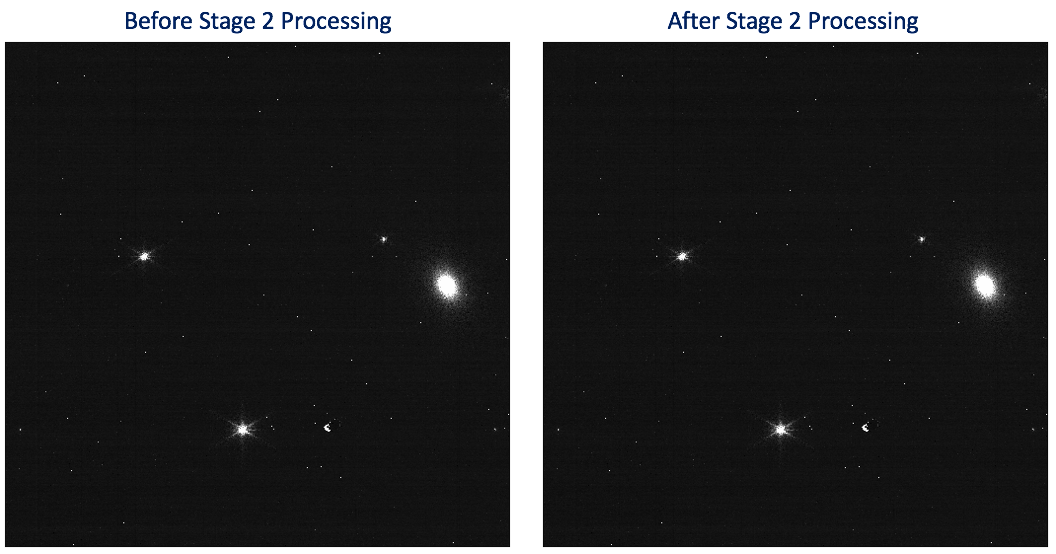

In [9]:
Image("image2_example.png")

Here is the data format after Stage 2 processing: 

In [49]:
fits.info("V54321001002P0000000001108_A1_F150W_cal.fits")

Filename: V54321001002P0000000001108_A1_F150W_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     225   ()      
  1  SCI           1 ImageHDU        46   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  ASDF          1 NonstandardExtHDU      8   ()      


***
<a id='image3'></a>
## 11. Stage 3 Image Processing: Source catalogs and mosaics

Stage 3 imaging (Image3, calwebb_image3) processing is intended for combining the calibrated data from multiple exposures (e.g., a dither or mosaic pattern) into a single distortion corrected product. Before being combined, the exposures receive additional corrections for the purpose of astrometric alignment, background matching, and outlier rejection. 

> **Inputs**: The inputs to calwebb_image3 will usually be in the form of an ASN file that lists multiple associated 2D calibrated exposures to be processed and combined into a single product. The individual exposures should be calibrated ("cal") from calwebb_image2 processing. It is also possible use a single "cal" file as input, in which case only the resample and source_catalog steps will be applied.

> **Outputs**: A resampled/rectified 2D image product with suffix "i2d" is created, containing the rectified single exposure or the rectified and combined association of exposures (the direct output of the resample step). A source catalog produced from the "i2d" product is saved as an ASCII file in "ecsv" format, with a suffix of "cat". If the outlier_detection step is applied, a new version of each input calibrated exposure product is created, which contains a DQ array that has been updated to flag pixels detected as outliers. This updated product is known as a CR-flagged product and the file is identified by including the association candidate ID in the original input "cal" file name and changing the suffix to "crf".
    

Steps for NIRCam:

**Tweakreg** (jwst.tweakreg, tweakreg_step, TweakRegStep)

**Sky Match** (jwst.skymatch, skymatch_step, SkyMatchStep)

**Outlier Detection** (jwst.outlier_detection, outlier_detection_step, OutlierDetectionStep)

**Resample** (jwst.resample, resample_step, ResampleStep)

**Source Catalog** (jwst.source_catalog, source_catalog_step, SourceCatalogStep)

(for more information on individual steps see: https://jwst-pipeline.readthedocs.io/en/latest/jwst/package_index.html)

   ### Image 3 Association Table

Here, I use an association table to generate a combined image. Below is my example association (you can also put a single image in the association table):

```python
{
    "asn_id": "a3001",
    "asn_pool": "none",
    "asn_rule": "Asn_Image",
    "program": "54321",
    "asn_type": "image3",
    "constraints": "No constraints",
    "code_version": "0.9.4",
    "target": "none",
    "version_id": null,
    "degraded_status": "No known degraded exposures in association.",
    "products": [
        {
            "name": "mosaic_A1-A4_obs1-8",
            "members": [
                {
                    "expname": "V54321001002P0000000001101_A1_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001101_A2_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001101_A3_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001101_A4_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001102_A1_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001102_A2_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001102_A3_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001102_A4_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001103_A1_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001103_A2_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001103_A3_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001103_A4_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001104_A1_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001104_A2_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001104_A3_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001104_A4_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001105_A1_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001105_A2_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001105_A3_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001105_A4_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001106_A1_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001106_A2_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001106_A3_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001106_A4_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001107_A1_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001107_A2_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001107_A3_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001107_A4_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001108_A1_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001108_A2_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001108_A3_F150W_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "V54321001002P0000000001108_A4_F150W_cal.fits",
                    "exptype": "science"
                }
            ]
        }
    ]
}
```

   ### Running the pipeline

In [ ]:
# Run the pipeline ---------------------------------------------------------------

from jwst.pipeline import calwebb_image3

# association table containing exposures to calibrate
association = "image3_obs1-8_asn.json"

m = calwebb_image3.Image3Pipeline(config_file='calwebb_image3.cfg')

# # you can still skip steps and override reference files
m.outlier_detection.skip = True
m.source_catalog.snr_threshold = 20

# run the pipeline with these paramters
m.run(association)

This will generate a final source catalog ("cat.ecsv"), a final 2D image ("i2d.fits"), individual exposures with DQ array flagged for outliers ("crf.fits"), and blot images from the outlier detection step ("blot.fits"). Changing the SNR threshold for the source catalog step will reduce the number of false detections.

   ### Caveats!

>1. Values in the photom reference file are dummy values, so the magnitudes in the catalog are not correct.
>1. We only use some exposures (2 primary dithers rather than 3) from the entire set of simulations because the pipeline crashes when all 48 exposures are included. 

   ### Source catalog

In [4]:
# below is an example source catalog product
from astropy.table import Table

catalog = Table.read("mosaic_A1-A4_obs1-8_cat.ecsv",format='ascii.ecsv')
catalog

<Table length=2630>
  id      xcentroid          ycentroid      ...       abmag       abmag_error
             pix                pix         ...                              
int64      float64            float64       ...      float64        float32  
----- ------------------ ------------------ ... ----------------- -----------
    1 1817.4726091396628 12.513963418458493 ... 66.76402282714844  0.08964163
    2 1694.4373359056783 14.184450589628886 ...  67.0096664428711 0.100980505
    3 2055.8803623109197 14.285402145473507 ... 66.47968292236328  0.07798301
    4 2862.9873716046354  13.69301009411382 ... 67.17152404785156   0.1099639
    5 1078.5363893077588 15.518089118170458 ... 66.42699432373047 0.077227294
    6 2560.8621125755226   15.1594231207935 ... 67.27580261230469  0.11487518
    7 2745.1999808583687 14.385668233112504 ... 67.60418701171875   0.1348635
    8   2774.74375753433 14.991197146285709 ...  67.1375732421875 0.109144054
    9  786.4013945103505  16.80565498035305 ...  67.4781265258789  0.12613009
  ...                ...                ... ...               ...         ...
 2621 3727.3546409699097  4746.656058104399 ... 66.04821014404297 0.064863235
 2622 4245.6537845753455  4746.572877627949 ... 66.97371673583984  0.10093645
 2623 3962.0432352326065  4748.219404545757 ... 66.14292907714844  0.06845979
 2624 3979.0113416767613  4749.009457219623 ... 67.48992156982422  0.12691772
 2625 3983.3186923326703  4749.348304717311 ... 67.44371032714844  0.12560919
 2626  3608.032278039442  4755.014768261712 ... 67.14363861083984  0.10835034
 2627  3713.283849705155  4755.152458300272 ... 66.93111419677734 0.097804904
 2628 3968.6156793759856  4756.209658125003 ... 67.59101867675781   0.1339177
 2629 3953.9710048475804 4758.8111058718005 ... 65.94967651367188  0.06273956
 2630 3965.3066421913095  4761.555596428432 ... 66.20317077636719   0.0684616

   ### Combined image

The image below shows the final combined image ("i2d.fits") after calwebb_image3. 

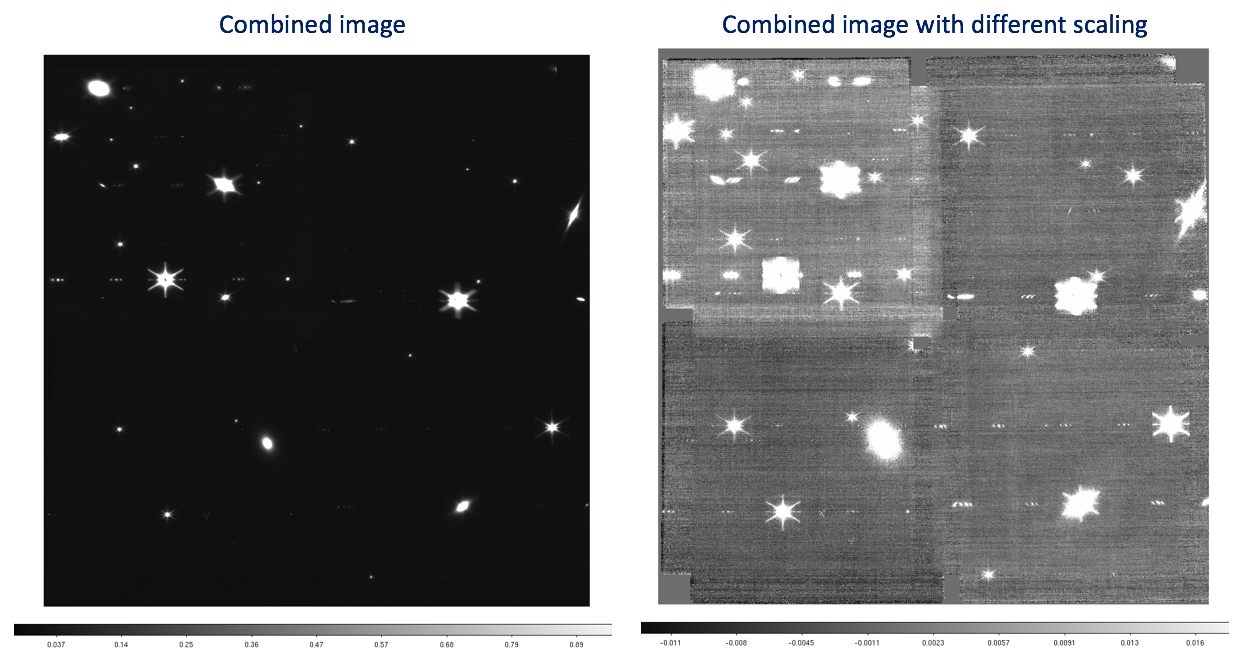

In [10]:
Image("image3_example.png")

Changing the SNR threshold reduces false detections in the source catalog.

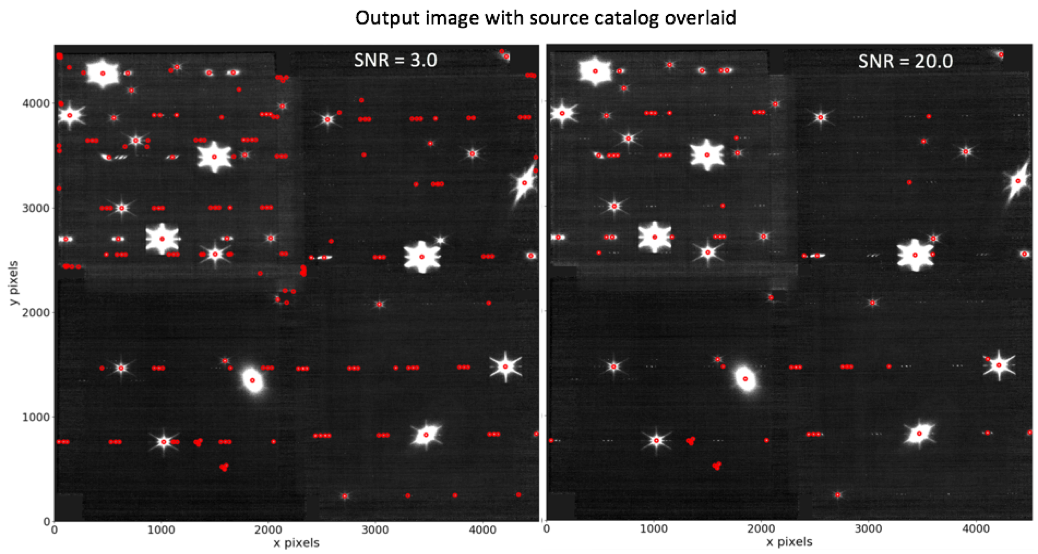

In [11]:
Image("catalog_overlay.png")

Here is the data format for the final combined image ("i2d.fits"):

In [5]:
fits.info("mosaic_A1-A4_obs1-9_obsabc_i2d.fits")

Filename: mosaic_A1-A4_obs1-9_obsabc_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     251   ()      
  1  SCI           1 ImageHDU        46   (4524, 4561)   float32   
  2  CON           1 ImageHDU         9   (4524, 4561)   int32   
  3  WHT           1 ImageHDU         9   (4524, 4561)   float32   
  4  ASDF          1 NonstandardExtHDU      8   ()      


   ### Direct image

The source catalog step of the Stage 3 imaging pipeline can be used to generate catalogs for the spectroscopic pipeline. For this set of simulated SW images, we also have grism observations taken with the LW channel. Running the observation from the last dither position for this set of images through the calwebb_image3 pipeline alone generates a source catalog for simulated grism observations that can then be fed into the Stage 2 pipeline for spectroscopy, discussed in the [Stage 2 Spectroscopic Processing](#spec2) section. 

***
<a id='spec2'></a>
## 12. Stage 2 Spectroscopic Processing:  Calibrated individual exposures

Stage 2 spectroscopic (Spec2, calwebb_spec2) pipeline applies additional corrections to countrate products that result in fully calibrated individual exposures. 

> **Inputs**: The input to the calwebb_spec2 pipeline can be either a single countrate ("rate" or "rateints") exposure or an ASN table listing multiple exposures. The background subtraction (bkg_subtract) step can only be executed when the pipeline is supplied with an association of exposures, because it relies on multiple exposures to perform their tasks. The ASN file must not only list the input exposures, but must also contain information that indicates their relationships to one another. Background subtraction for Wide-Field Slitless Spectroscopy (WFSS) exposures is accomplished by scaling and subtracting a master background image from a CRDS reference file.
If a single countrate product is used as input, the background subtraction step will be skipped and only the remaining regular calibration steps will be applied to the input exposure.

> **Outputs**: Two different types of outputs are created by calwebb_spec2. 1.) A fully-calibrated product at the end of the photom step, which uses the "cal" or "calints" suffix, depending on whether the input was a "rate" or "rateints" product, respectively. 2.) A 1D extracted spectral data product, which is saved as a "x1d" or "x1dints" file, depending on the input type. If the input to calwebb_spec2 is an ASN file, these products are created for each input exposure.
    



Steps for NIRCam:

**Background Subtract** (jwst.background, background_sub)
* Reference file: WFSS background (actual bkg image), wavelength range 

**Assign WCS** (jwst.assign_wcs, assign_wcs_step, AssignWcsStep)
* Reference file: distortion

**Extract 2D** (jwst.extract_2d, extract_2d_step, Extract2dStep)
* Reference file: wavelength range 

**Flat Field** (jwst.flat_field, flat_field_step, FlatFieldStep)
* Reference file: flat field

**Source Type** (jwst.srctype, srctype_step, SourceTypeStep)

**Photometric Correction** (jwst.photom, photom_step, PhotomStep)
* Reference file: photometric conversion

**Extract 1D** (jwst.extract_1d, extract_1d_step, Extract1dStep)

(for more information on individual steps see: https://jwst-pipeline.readthedocs.io/en/latest/jwst/package_index.html)

   ### Association table

Though you can run individual steps of this pipeline (e.g., run only Assign WCS to associate a WCS object with an exposure), we will run the full Stage 2 spectroscopic pipeline on one exposure in an association table (with the source catalog). We don't have a background exposure for this observation.

An example association table is shown below: 


```python
{
    "asn_type": "None",
    "version_id": null,
    "target": "none",
    "code_version": "0.9.4",
    "asn_rule": "Asn_Lv2Spec",
    "asn_pool": "none",
    "program": "54321",
    "asn_type": "spec2",
    "products": [
        {
            "name": "V54321001002P0000000001109_A5_F410M_rate_dispersed_GRISMR_crossing_F444W_extract1D",
            "members": [
                {
                    "exptype": "science",
                    "expname": "V54321001002P0000000001109_A5_F410M_rate_dispersed_GRISMR_crossing_F444W_rate.fits"
                },
                {
                    "exptype": "sourcecat",
                    "expname": "V54321001002P000000000110d_A5_F444W_directImage_cat_3sources.ecsv"
                }
            ]
        }
    ]
}
```

   ### Caveats!

>1. This pipeline has only been roughly tested to make sure it runs without errors; however, preliminary results are available. 
>2. Extract 2D runs extremely slowly, so it is best to reduce the number of sources in the source catalog (we reduced it to 3 sources). 
>3. Values in the photom reference file are dummy values.

```python
# Run the pipeline ---------------------------------------------------------------

from jwst.pipeline import calwebb_spec2

# association table containing exposures to calibrate
association = "spec2_1obs_asn.json"

m = calwebb_spec2.Spec2Pipeline(config_file='calwebb_spec2.cfg')

# run the pipeline with these paramters
m.run(association)
```

The image below shows an example of the direct image with 3 chosen sources from the catalog circled and the dispersed image.

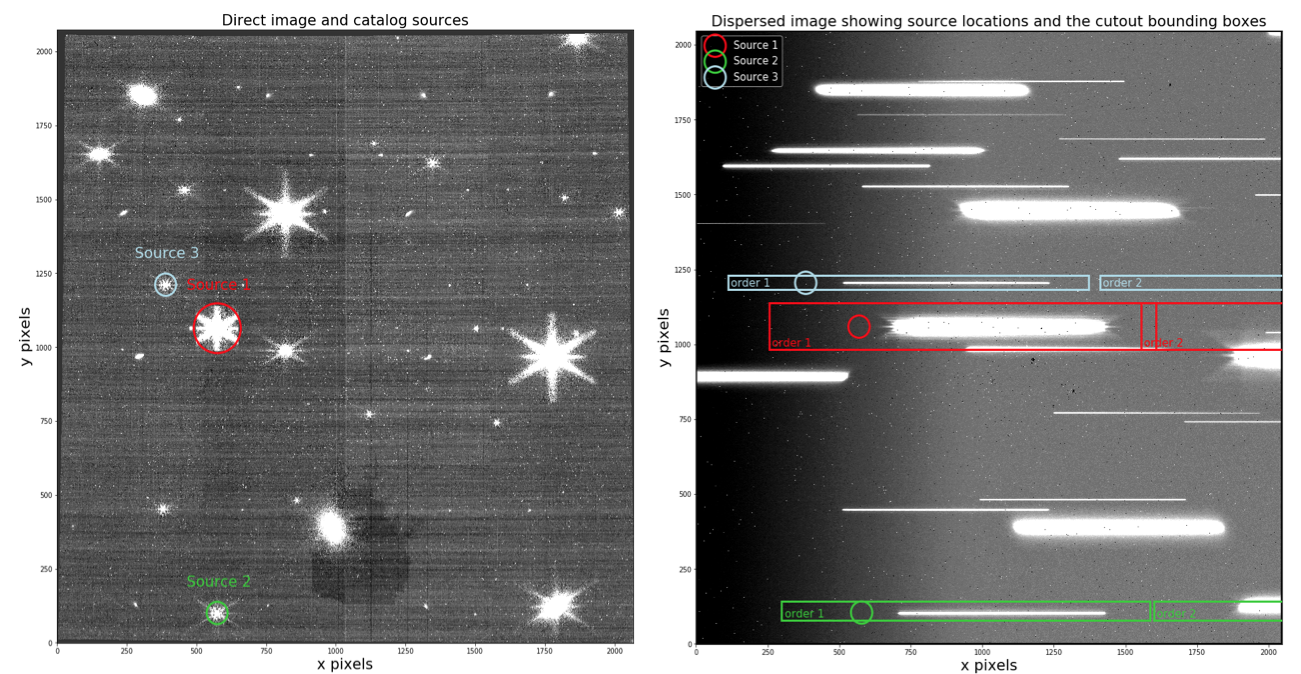

In [12]:
Image("spec2_example.png")

The image below shows an example of cutouts made by the Extract 2D step.

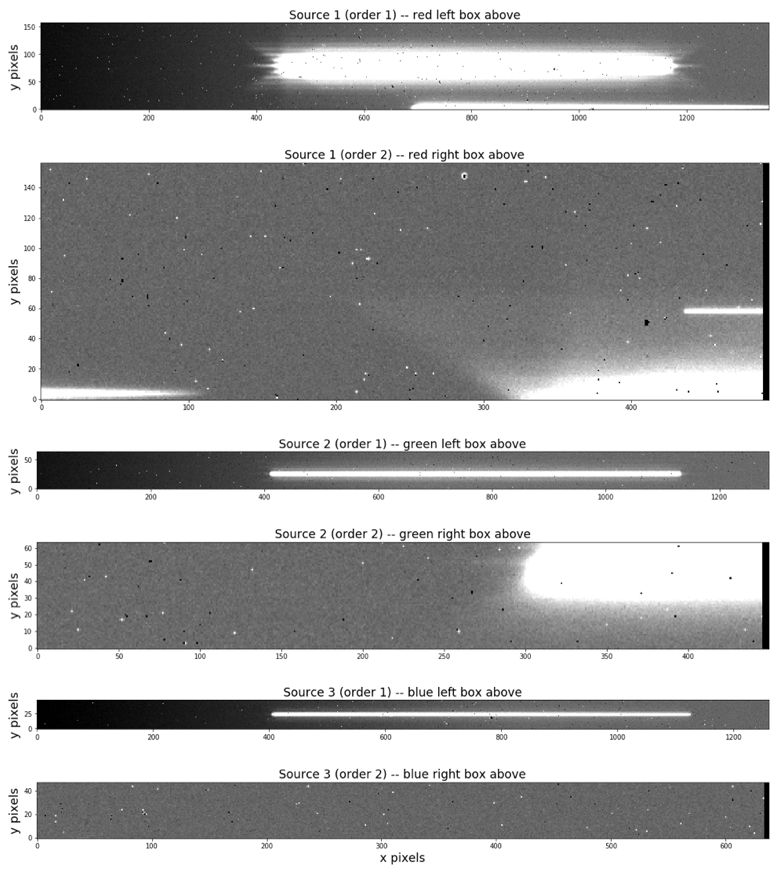

In [13]:
Image("extract2d_example.png")

Data format before calwebb_spec2 pipeline: 

In [9]:
fits.info("../../spec2/V54321001002P0000000001109_A5_F410M_rate_dispersed_GRISMR_crossing_F444W_rate.fits")

Filename: ../../spec2/V54321001002P0000000001109_A5_F410M_rate_dispersed_GRISMR_crossing_F444W_rate.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     143   ()      
  1  SCI           1 ImageHDU        41   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  6  ASDF          1 ImageHDU         7   (4181,)   uint8   


Finally, here is the data format after the full calwebb_spec2 pipeline. There is one extension for each source and each order (3 sources, 2 orders), even though there are no second order spectra for this filter. 

In [11]:
fits.info("../../spec2/V54321001002P0000000001109_A5_F410M_rate_dispersed_GRISMR_crossing_F444W_extract1D_x1d.fits")

Filename: ../../spec2/V54321001002P0000000001109_A5_F410M_rate_dispersed_GRISMR_crossing_F444W_extract1D_x1d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     229   ()      
  1  EXTRACT1D     1 BinTableHDU     35   1353R x 8C   [D, D, D, J, D, D, D, D]   
  2  EXTRACT1D     2 BinTableHDU     35   494R x 8C   [D, D, D, J, D, D, D, D]   
  3  EXTRACT1D     3 BinTableHDU     35   1287R x 8C   [D, D, D, J, D, D, D, D]   
  4  EXTRACT1D     4 BinTableHDU     35   450R x 8C   [D, D, D, J, D, D, D, D]   
  5  EXTRACT1D     5 BinTableHDU     35   1261R x 8C   [D, D, D, J, D, D, D, D]   
  6  EXTRACT1D     6 BinTableHDU     35   638R x 8C   [D, D, D, J, D, D, D, D]   
  7  ASDF          1 NonstandardExtHDU      8   ()      
